In [11]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
import wfdb
import copy as cp
import scipy.signal as signal
import pickle
from sklearn import preprocessing
from tqdm import tqdm
import os
import re
import pandas as pd
import csv
import seaborn as sns
from matplotlib.axis import Axis
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

# Process Information Taken from Raw Files

## Import our Previously Extracted Data

In [4]:
record_list = [] # Initialize the array that will hold the list of our records

records = 'mit-bih-dataframes/subject_list.csv' # Get our record list like we did in the initial extraction
with open(records) as rfile:# Load our records into the array
    for record in rfile:
        record = record[0:-1] # The -1 removes the newline ("\n") character from the string
        record_list.append(record)

In [5]:
subject_dataframes = [] # Initialize our dataframe array

for x in tqdm(record_list): # Extract our dataframes from the CSVs we saved previously
    subject_dataframes.append(pd.read_csv('mit-bih-dataframes/'+x+'.csv', index_col=0))
            # 'index_col=0' loads the index that is saved into the csv as the index rather than another column

100%|██████████| 23/23 [03:19<00:00,  8.68s/it]


In [6]:

# Now we get the indexes of the R-Peaks from our dataframes
qrs = [] # Initialize the array that will hold our list of R-Peaks for each subject

for subject in tqdm(subject_dataframes): # Load each subject
    qrs.append([idx for idx, x in enumerate(subject['R-Peak']) if x]) # Then we use list comprehension to get our r peaks for each subject
                                                                # Recall, the indices that the R-Peak column is true is where there is an r-peak
                                                                # So, we iterate through and identify which indices that is for each subject

100%|██████████| 23/23 [00:41<00:00,  1.79s/it]


In [212]:
#print(subject_dataframes[1])
#print(qrs[1])

## Extract RR-Intervals

In 2019, all of our developed variables were based on RR-Intervals, or the distance between adjacent R-Peaks. So, that is the first thing we extract 

In [7]:
rr_ints = [] # Initialize the array that will hold all of our subjects' RR-Intervals

# Then we want to Go through all of our data that holds our R-Peaks [That will be the qrs array]
# Iterating through that we want to extract the interval between each peak. 
# My suggested format is: 
"""
for each subject:
    for each rpeak sample_num in my current subject:
        subject_rrinterval.append( rpeak sample_num - the sample_num before it)
"""
for subject in tqdm(qrs):
    temp_array = []
    for index, rpeak in enumerate(subject):
        if index != 0:
            temp_array.append(rpeak - subject[index-1])
    rr_ints.append(temp_array)
#print(rr_ints[0])

100%|██████████| 23/23 [00:00<00:00, 31.83it/s]


In [8]:
rr_timeints = []
for subject in rr_ints:
    subject_time = []
    for interval in subject:
        time = interval/250
        subject_time.append(time)
    rr_timeints.append(subject_time)

In [9]:
#from Tutorial_Extract_MIT-BIH import atr_labels
subject_list = []
for integer in tqdm(range(0, 23)):    
    df = pd.DataFrame(
        {
            "Interval": rr_timeints[integer],
            "R-Peak": qrs[integer][1:],
            "Afib": subject_dataframes[integer]['AFIB'][qrs[integer][1:]],
            "Normal": subject_dataframes[integer]['Normal'][qrs[integer][1:]],
            "Other": subject_dataframes[integer]['Other'][qrs[integer][1:]],
    #        "Rhythm": main_list,
    #        'Indexes': index_list
        }
    )
    typelist = ['Normal', 'Afib', 'Other']
    main_list = []
    for index, row in df.iterrows():
        for types in typelist:
                if types == 'Normal' and row['Normal']:
                    main_list.append('N')
                elif types == 'Afib' and row['Afib']:
                    main_list.append('A')
                elif types == 'Other' and row['Other']:
                    main_list.append('O')
    df = df.assign(Rhythm=main_list)
    subject_list.append(df)

100%|██████████| 23/23 [01:53<00:00,  4.92s/it]


 87%|████████▋ | 20/23 [00:11<00:01,  1.84it/s]C:\Users\Luke\AppData\Local\Temp\ipykernel_19012\1329143778.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize=(15,3)) #plot subplots
100%|██████████| 23/23 [00:13<00:00,  1.70it/s]


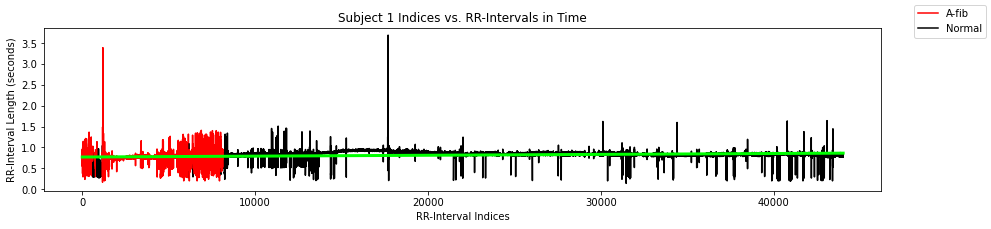

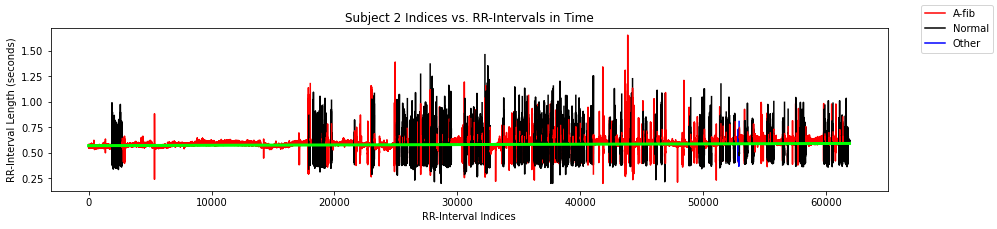

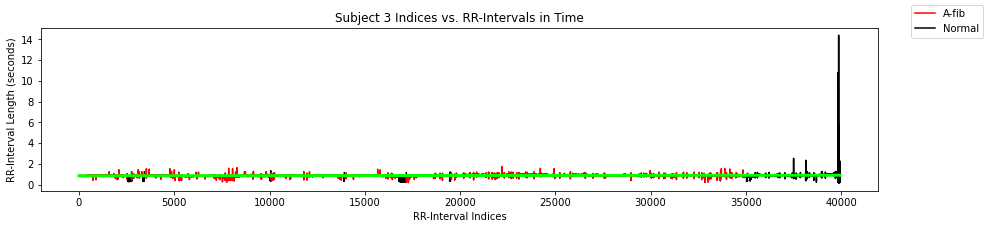

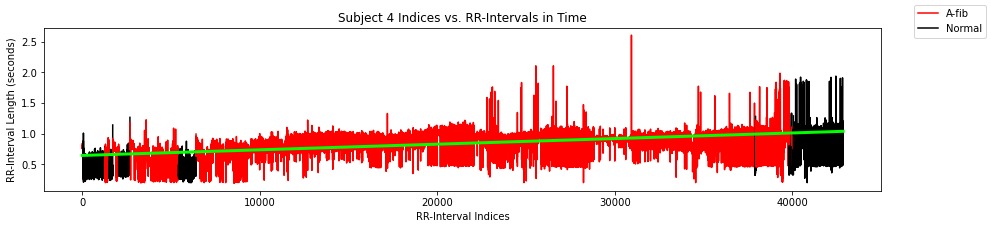

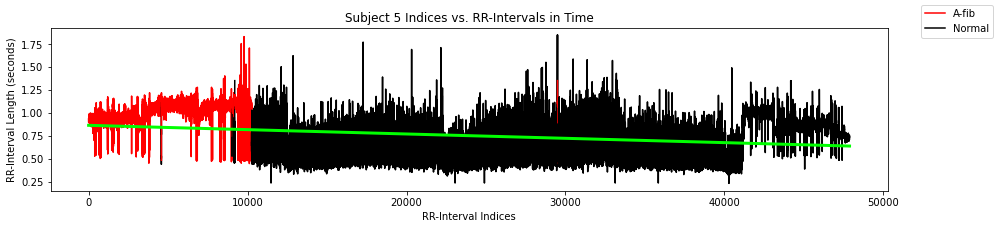

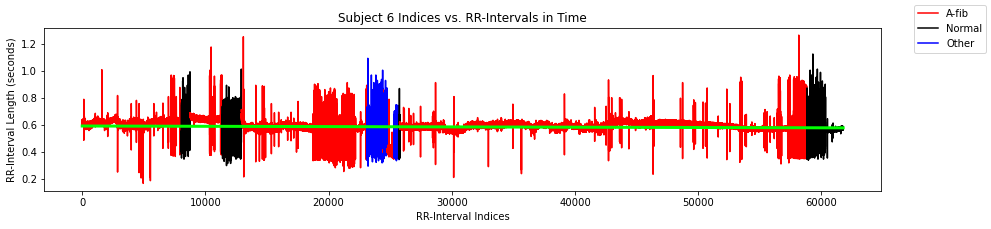

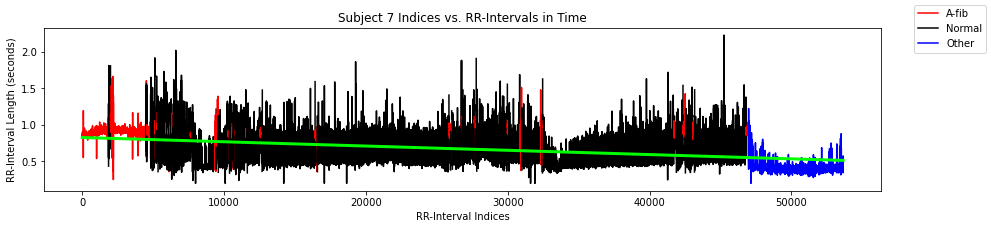

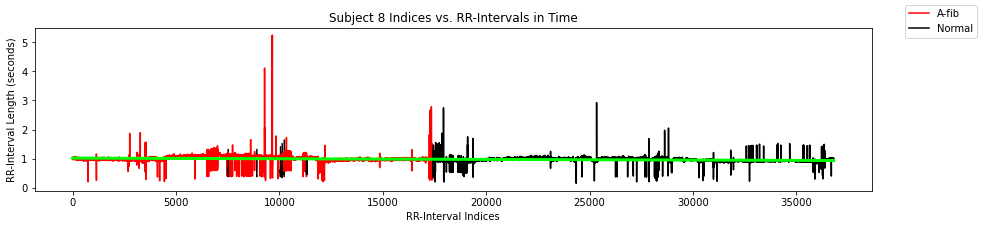

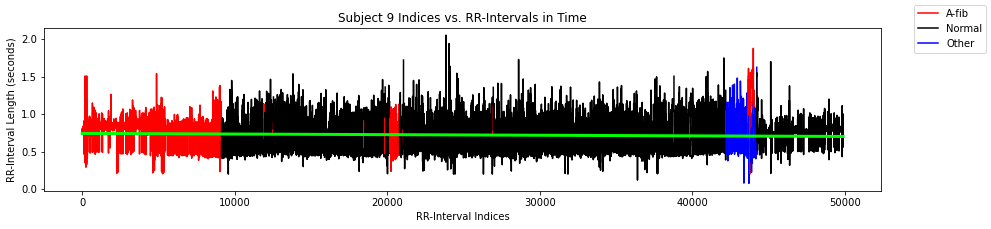

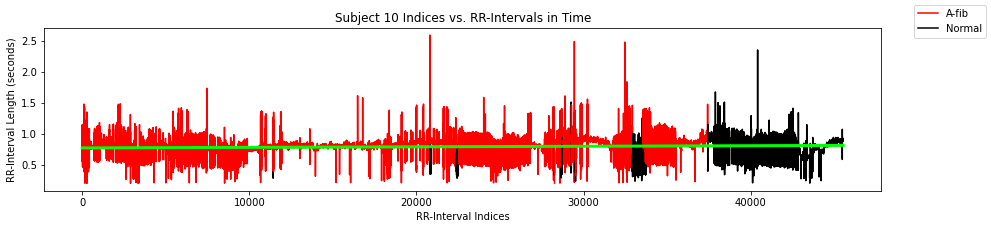

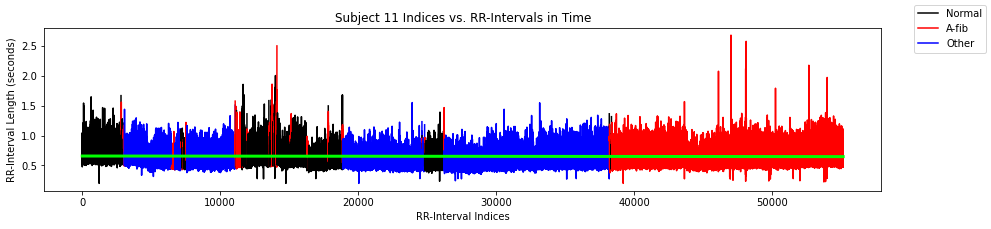

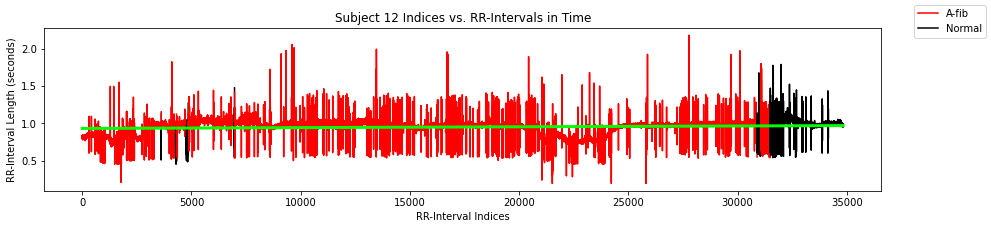

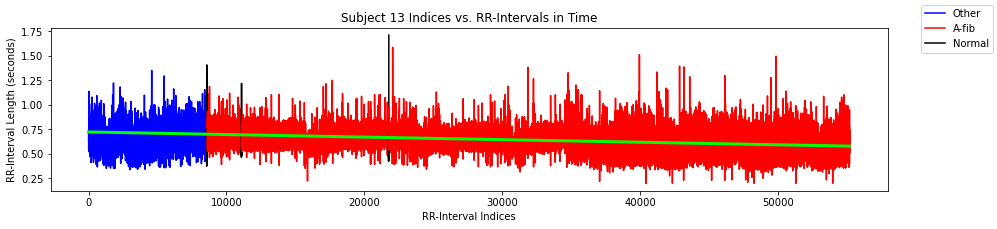

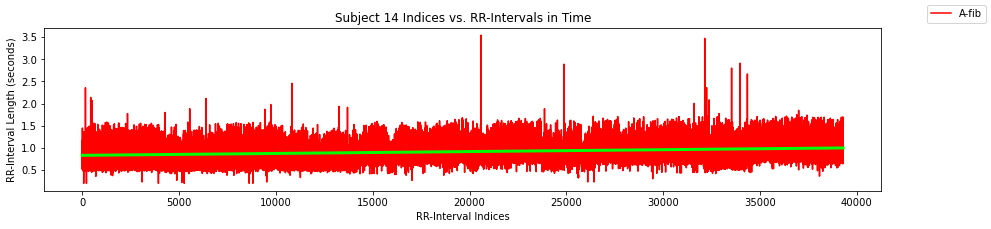

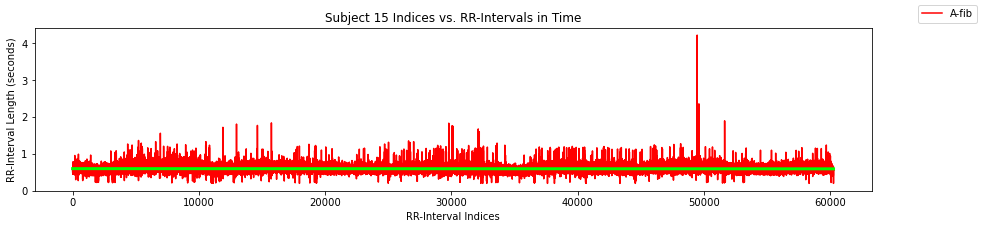

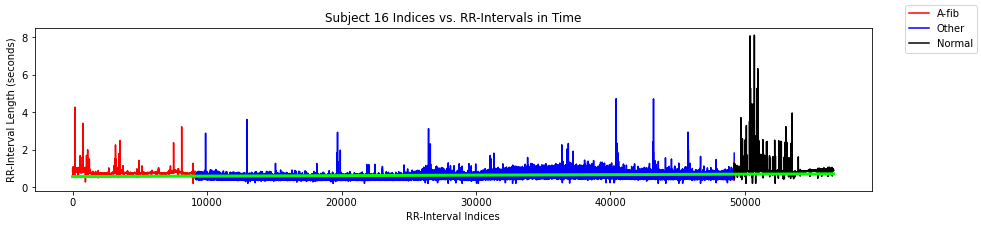

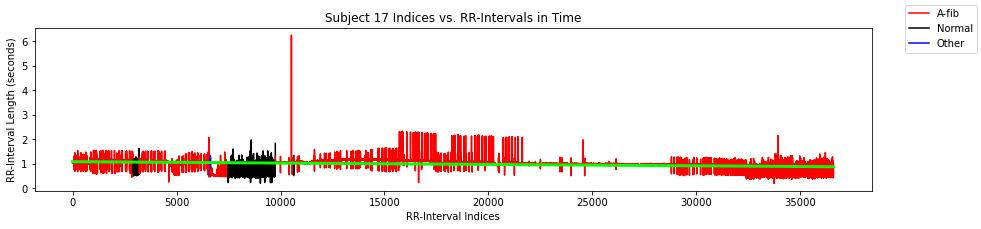

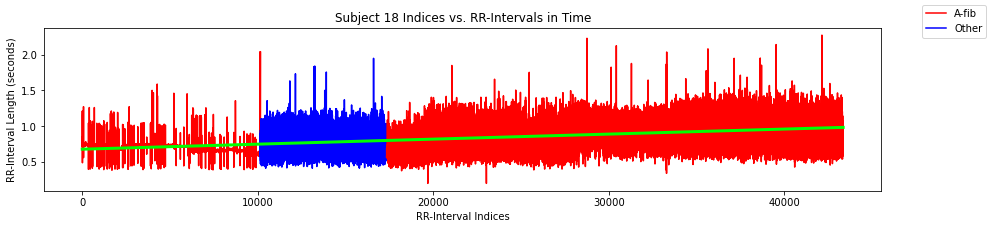

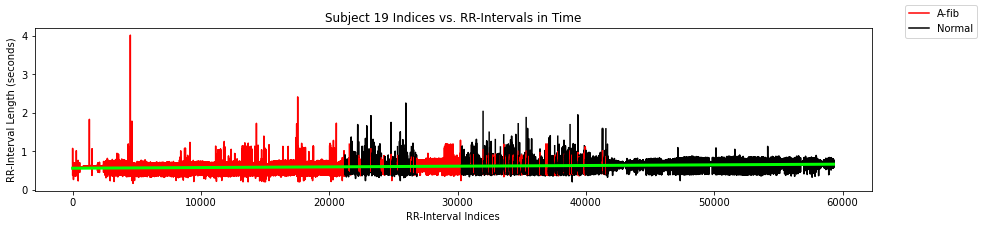

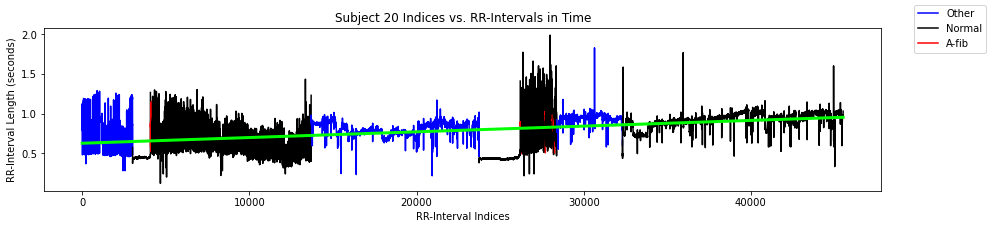

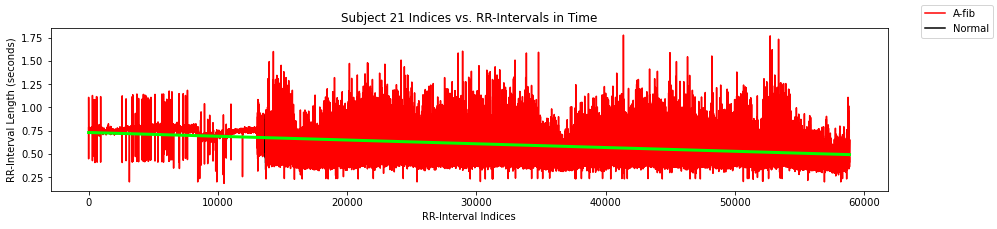

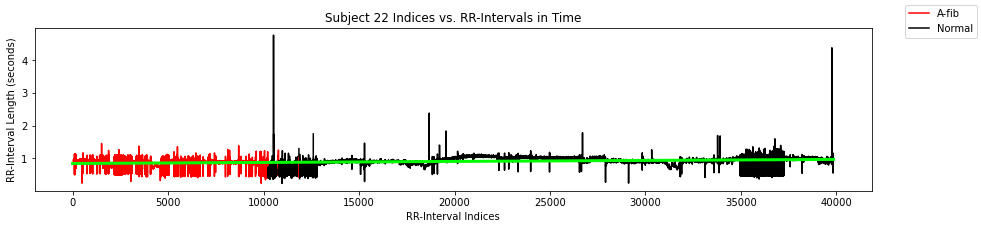

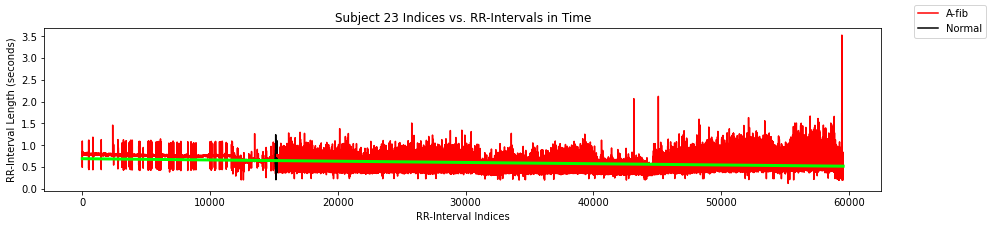

In [8]:
comp = '' #Compare when df['Rhythm'] changes from normal to Afib
counter = 0 #Upper bound for line
mini = 0 #(Minimum) Lower bound for line
subject_counter = 0 #Retrieve the specific subject array from rr_timeints
#labels = 'Red = A-fib, Black = Normal, Green = Other'

for df in tqdm(subject_list): #iterate through all subjects
    
    comp = ''
    counter = 0
    mini = 0
    ins_norm_counter = 0 #for figure legend
    ins_other_counter = 0 #for figure legend
    ins_afib_counter = 0 #for figure legend
    fig, axs = plt.subplots(figsize=(15,3)) #plot subplots
    plt.title('Subject ' + str(subject_counter+1) + ' Indices vs. RR-Intervals in Time')
    plt.xlabel('RR-Interval Indices')
    plt.ylabel('RR-Interval Length (seconds)')
    
    #Set x and y for line of best fit
    upper = len(df['Rhythm'])
    indices_list = []
    for num in range(0, upper):
        indices_list.append(num)
    x = np.array(indices_list)
    y = rr_timeints[subject_counter]
    
    #find line of best fit
    a, b = np.polyfit(x, y, 1)
            
    
    
    for item in df['Rhythm']: #iterate through each letter (rhythm) in each dataframe for each subject
        
        counter += 1
        
        if item != comp and comp != '':
            
            if item == 'N':
                if ins_norm_counter == 0:
                    axs.plot(range(mini, counter), rr_timeints[subject_counter][mini:counter], color='black',label = 'Normal')
                    ins_norm_counter += 1
                else:
                    axs.plot(range(mini, counter), rr_timeints[subject_counter][mini:counter], color='black')
            
            if item == 'O':
                if ins_other_counter == 0:
                    axs.plot(range(mini, counter), rr_timeints[subject_counter][mini:counter], color='b',label = 'Other')
                    ins_other_counter += 1
                else:
                    axs.plot(range(mini, counter), rr_timeints[subject_counter][mini:counter], color='b')
            
            if item == 'A':
                if ins_afib_counter == 0:
                    axs.plot(range(mini, counter), rr_timeints[subject_counter][mini:counter], color='red',label = 'A-fib')
                    ins_afib_counter += 1
                else:
                    axs.plot(range(mini, counter), rr_timeints[subject_counter][mini:counter], color='red')
            mini = counter #resets starting x to new one
        
        elif counter == len(df['Rhythm']):
            
            if item == 'N':
                if ins_norm_counter == 0:
                    axs.plot(range(mini, counter), rr_timeints[subject_counter][mini:counter], color='black',label = 'Normal')
                    ins_norm_counter += 1
                else:
                    axs.plot(range(mini, counter), rr_timeints[subject_counter][mini:counter], color='black')
            
            if item == 'O':
                if ins_other_counter == 0:
                    axs.plot(range(mini, counter), rr_timeints[subject_counter][mini:counter], color='b',label = 'Other')
                    ins_other_counter += 1
                else:
                    axs.plot(range(mini, counter), rr_timeints[subject_counter][mini:counter], color='b')
            
            if item == 'A':
                if ins_afib_counter == 0:
                    axs.plot(range(mini, counter), rr_timeints[subject_counter][mini:counter], color='red',label = 'A-fib')
                    ins_afib_counter += 1
                else:
                    axs.plot(range(mini, counter), rr_timeints[subject_counter][mini:counter], color='red')
        
        comp = item #comparator for each item in df['Rhythm']
    
    subject_counter += 1
    fig.legend(loc='upper right') #show legends
    
    #add line of best fit to plot
    l1 = plt.plot(x, a*x+b, color='lime',linewidth=3)

        
plt.show()

In [40]:
#SEE HISTOGRAMS BELOW

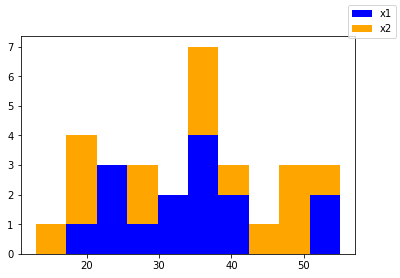

In [28]:
#Example for how to stack histograms
x1= [23, 25, 40, 35, 40, 53, 33, 28, 55, 34, 20, 37, 36, 23, 33]
x2= [36, 20, 27, 50, 34, 47, 18, 28, 52, 21, 44, 34, 13, 40, 49]
colors = ['blue', 'orange']
labels = ['x1', 'x2']
fig, axs = plt.subplots()
axs.hist([x1, x2], stacked = True, color=colors, label = labels)
fig.legend(loc='upper right')

 87%|████████▋ | 20/23 [00:02<00:00,  7.48it/s]C:\Users\Luke\AppData\Local\Temp\ipykernel_1860\297702804.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots()
100%|██████████| 23/23 [00:03<00:00,  7.58it/s]


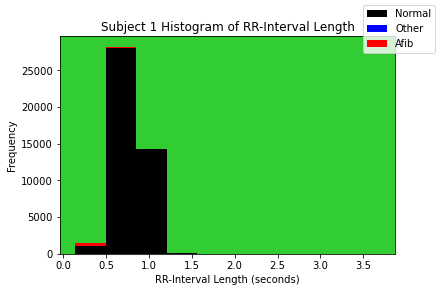

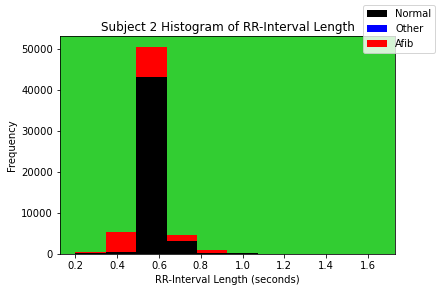

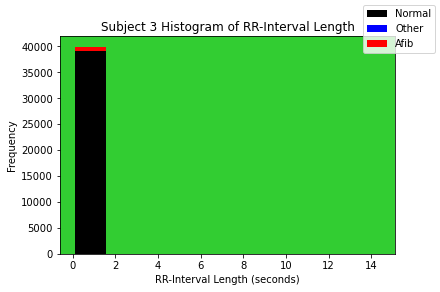

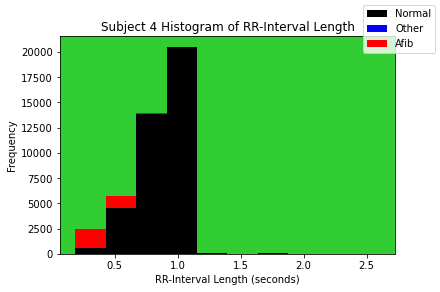

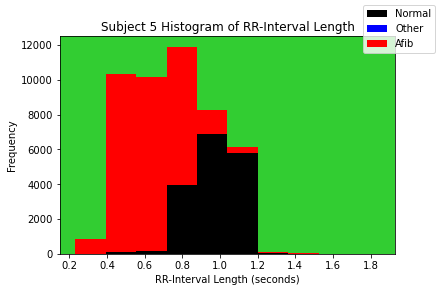

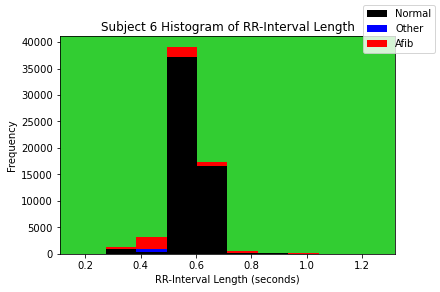

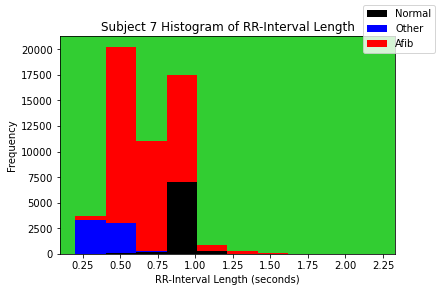

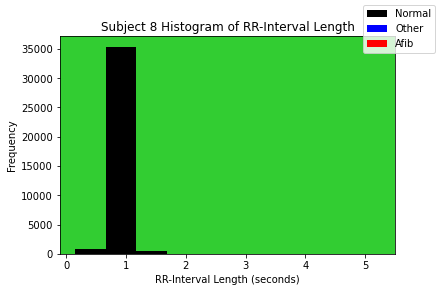

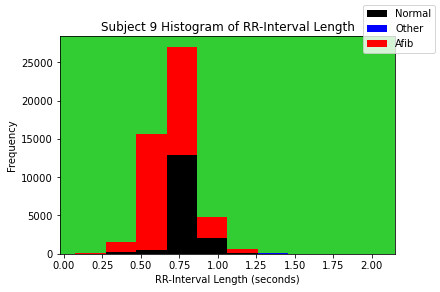

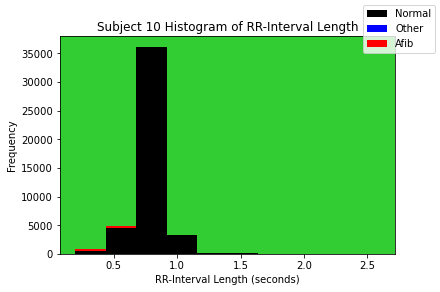

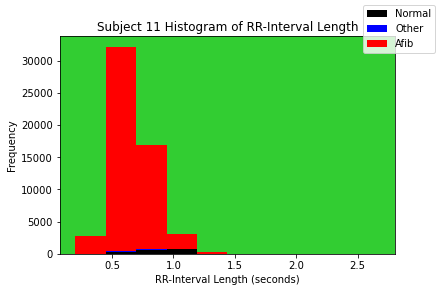

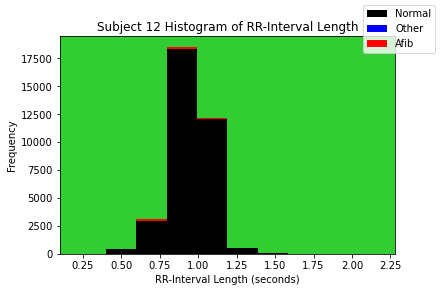

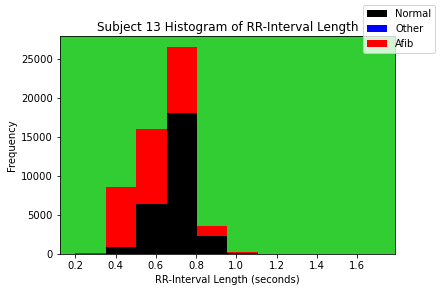

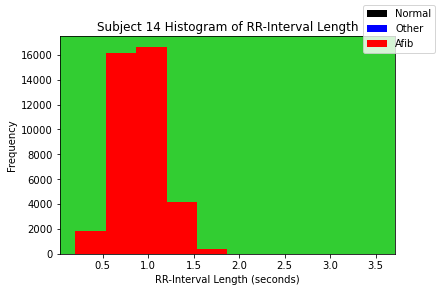

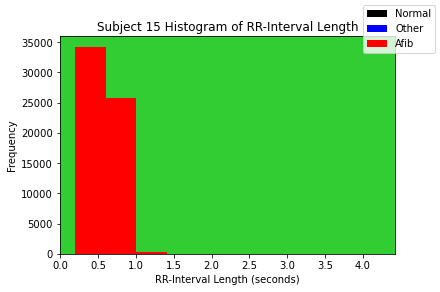

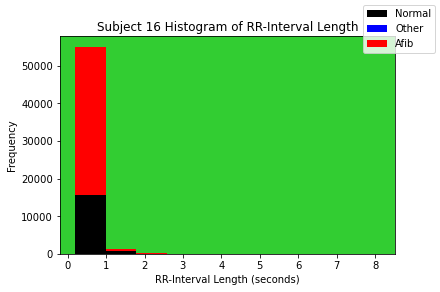

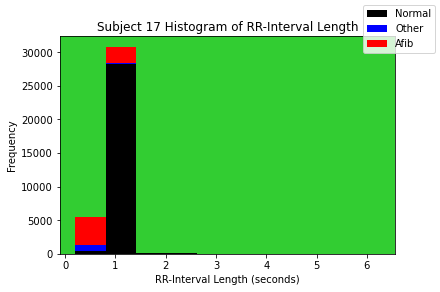

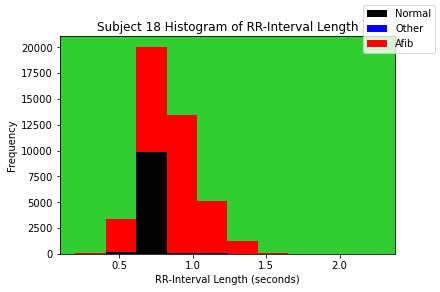

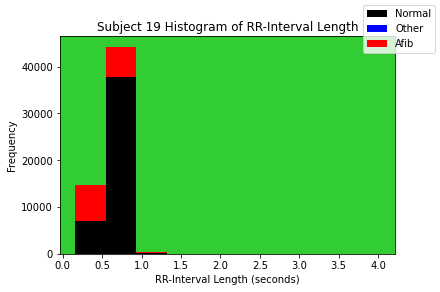

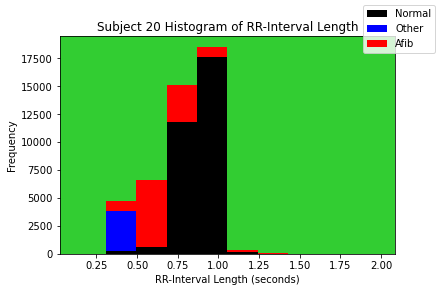

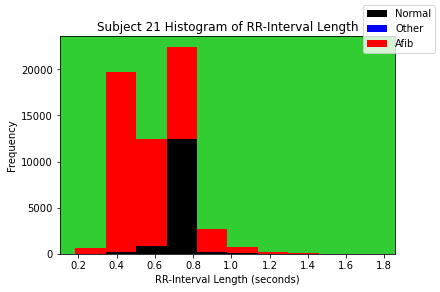

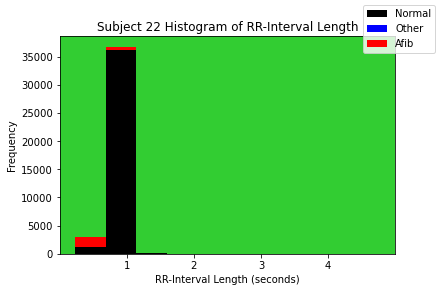

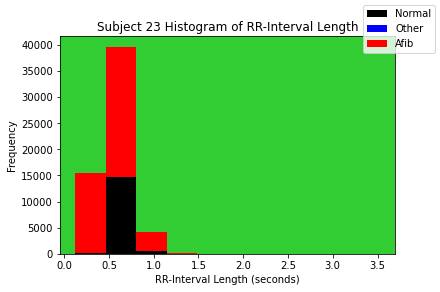

In [31]:
colors = ['black', 'b', 'r']
labels = ['Normal', 'Other', 'Afib']
for integer in tqdm(range(0, 23)):
    normal_list = []
    other_list = []
    afib_list = []
    counter = 0
    
    fig, axs = plt.subplots()
    plt.title('Subject ' + str(integer+1) + ' Histogram of RR-Interval Length')
    plt.xlabel('RR-Interval Length (seconds)')
    plt.ylabel('Frequency')
    
    for item in subject_list[integer]['Rhythm']:
        if item == 'N':
            normal_list.append(rr_timeints[integer][counter])
            counter += 1
        elif item == 'O':
            other_list.append(rr_timeints[integer][counter])
            counter += 1
        elif item == 'A':
            afib_list.append(rr_timeints[integer][counter])
            counter += 1
    
    axs.hist([normal_list, other_list, afib_list], stacked = True, color=colors, label = labels)
    fig.legend(loc='upper right')
    axs.set_facecolor('limegreen')
    

In [27]:
# comp = '' #Compare when df['Rhythm'] changes from normal to Afib
# #mini = 0 #(Minimum) Lower bound for line
# #subject_counter = 0 #Retrieve the specific subject array from rr_timeints
# #labels = 'Red = A-fib, Black = Normal, Green = Other'

# for integer in tqdm(range(0, 23)): #iterate through all subjects
    
#     comp = ''
#     temp_list = []
#     ins_norm_counter = 0 #for figure legend
#     ins_other_counter = 0 #for figure legend
#     ins_afib_counter = 0 #for figure legend   
    
#     counter = 0 #checks if plt.figure() command has been run, resets for every 
    
#     for item in df['Rhythm']: #iterate through each letter (rhythm) in each dataframe for each subject
        
        
#         if item != comp and comp != '':
            
#             for object1 in subject_list[integer]['Interval']: #this creates a list of all rr-interval lengths
#                 temp_list.append(object1)
            
#             if counter == 0: #makes sure that you only plot 1 figure for every subject
#                 plt.figure()
#                 counter += 1
            
#             else:
#                 continue
            
            
#             if item == 'N':
#                 if ins_norm_counter == 0:
#                     plt.hist(temp_list, bins = 40, color='black', label = 'Normal')
#                     plt.title('Subject ' + str(integer+1) + ' Histogram of RR-Interval Length')
#                     plt.xlabel('RR-Interval Length (seconds)')
#                     plt.ylabel('Frequency')
#                     ins_norm_counter += 1
#                 else:
#                     plt.hist(temp_list, bins = 40, color='black')
#                     plt.title('Subject ' + str(integer+1) + ' Histogram of RR-Interval Length')
#                     plt.xlabel('RR-Interval Length (seconds)')
#                     plt.ylabel('Frequency')
            
#             if item == 'O':
#                 if ins_other_counter == 0:
#                     plt.hist(temp_list, bins = 40, color='b', label = 'Other')
#                     plt.title('Subject ' + str(integer+1) + ' Histogram of RR-Interval Length')
#                     plt.xlabel('RR-Interval Length (seconds)')
#                     plt.ylabel('Frequency')
#                     ins_other_counter += 1
#                 else:
#                     plt.hist(temp_list, bins = 40, color='b')
#                     plt.title('Subject ' + str(integer+1) + ' Histogram of RR-Interval Length')
#                     plt.xlabel('RR-Interval Length (seconds)')
#                     plt.ylabel('Frequency')            
#             if item == 'A':
#                 if ins_afib_counter == 0:
#                     plt.hist(temp_list, bins = 40, color='red', label = 'A-fib')
#                     plt.title('Subject ' + str(integer+1) + ' Histogram of RR-Interval Length')
#                     plt.xlabel('RR-Interval Length (seconds)')
#                     plt.ylabel('Frequency')
#                     ins_afib_counter += 1
#                 else:
#                     plt.hist(temp_list, bins = 40, color='red')
#                     plt.title('Subject ' + str(integer+1) + ' Histogram of RR-Interval Length')
#                     plt.xlabel('RR-Interval Length (seconds)')
#                     plt.ylabel('Frequency')
        
#         elif counter == len(df['Rhythm']):
            
#             if item == 'N':
#                 if ins_norm_counter == 0:
#                     plt.hist(temp_list, bins = 40, color='black', label = 'Normal')
#                     plt.title('Subject ' + str(integer+1) + ' Histogram of RR-Interval Length')
#                     plt.xlabel('RR-Interval Length (seconds)')
#                     plt.ylabel('Frequency')                    
#                     ins_norm_counter += 1
#                 else:
#                     plt.hist(temp_list, bins = 40, color='black')
#                     plt.title('Subject ' + str(integer+1) + ' Histogram of RR-Interval Length')
#                     plt.xlabel('RR-Interval Length (seconds)')
#                     plt.ylabel('Frequency')
            
#             if item == 'O':
#                 if ins_other_counter == 0:
#                     plt.hist(temp_list, bins = 40, color='b', label = 'Other')
#                     plt.title('Subject ' + str(integer+1) + ' Histogram of RR-Interval Length')
#                     plt.xlabel('RR-Interval Length (seconds)')
#                     plt.ylabel('Frequency')                    
#                     ins_other_counter += 1
#                 else:
#                     plt.hist(temp_list, bins = 40, color='b', label = 'Other')
#                     plt.title('Subject ' + str(integer+1) + ' Histogram of RR-Interval Length')
#                     plt.xlabel('RR-Interval Length (seconds)')
#                     plt.ylabel('Frequency')            
#             if item == 'A':
#                 if ins_afib_counter == 0:
#                     plt.hist(temp_list, bins = 40, color='red', label = 'Afib')
#                     plt.title('Subject ' + str(integer+1) + ' Histogram of RR-Interval Length')
#                     plt.xlabel('RR-Interval Length (seconds)')
#                     plt.ylabel('Frequency')                    
#                     ins_afib_counter += 1
#                 else:
#                     plt.hist(temp_list, bins = 40, color='red', label = 'Afib')
#                     plt.title('Subject ' + str(integer+1) + ' Histogram of RR-Interval Length')
#                     plt.xlabel('RR-Interval Length (seconds)')
#                     plt.ylabel('Frequency')        
#         comp = item #comparator for each item in df['Rhythm']
    
#     #subject_counter += 1
#     fig.legend(loc='upper right') #show legends

# comp = '' #Compare when df['Rhythm'] changes from normal to Afib
# #mini = 0 #(Minimum) Lower bound for line
# #subject_counter = 0 #Retrieve the specific subject array from rr_timeints
# #labels = 'Red = A-fib, Black = Normal, Green = Other'

# for integer in tqdm(range(0, 23)): #iterate through all subjects
    
#     comp = ''
#     temp_list = []
#     ins_norm_counter = 0 #for figure legend
#     ins_other_counter = 0 #for figure legend
#     ins_afib_counter = 0 #for figure legend   
    
#     counter = 0 #checks if plt.figure() command has been run, resets for every 
#     fig, (ax0, ax1, ax2) = plt.subplots() #plot subplots
#     #plt.figure()
#     bins = 40
    
#     for object1 in subject_list[integer]['Interval']: #this creates a list of all rr-interval lengths
#         temp_list.append(object1)
    
#     stacked = False    
        
#     for item in subject_list[integer]['Rhythm']: #iterate through each letter (rhythm) in each dataframe for each subject
        
        
#         if item != comp and comp != '':
            
            
#             if item == 'N':
#                 if ins_norm_counter == 0:
#                     plt.hist(temp_list, bins, color='black', label='Normal', stacked = stacked)
                    
#                     ins_norm_counter += 1
#                 else:
#                     plt.hist(temp_list, bins, color='black', stacked = stacked)
            
#             if item == 'O':
#                 if ins_other_counter == 0:
#                     plt.hist(temp_list, bins, color='blue', label='Other', stacked = stacked)
                    
#                     ins_other_counter += 1
#                 else:
#                     plt.hist(temp_list, bins, color='blue')       
                    
#             if item == 'A':
#                 if ins_afib_counter == 0:
#                     plt.hist(temp_list, bins, color='red', label='Afib', stacked = stacked)
                    
#                     ins_afib_counter += 1
#                 else:
#                     plt.hist(temp_list, bins, color='red', stacked = stacked)
        
#         elif counter == len(df['Rhythm']):
            
#             if item == 'N':
#                 if ins_norm_counter == 0:
#                     plt.hist(temp_list, bins, color='black', label = 'Normal', stacked = stacked)
#                     ins_norm_counter += 1
#                 else:
#                     plt.hist(temp_list, bins, color='black', stacked = stacked)
            
#             if item == 'O':
#                 if ins_other_counter == 0:
#                     plt.hist(temp_list, bins, color='blue', label = 'Other', stacked = stacked)
#                     ins_other_counter += 1
#                 else:
#                     pyplot.hist(temp_list, bins, color='blue', stacked = stacked)
            
#             if item == 'A':
#                 if ins_afib_counter == 0:
#                     plt.hist(temp_list, bins, color='red', label='Afib', stacked = stacked)
#                     ins_afib_counter += 1
#                 else:
#                     pyplot.hist(temp_list, bins, color='red', stacked = stacked)
        
#         comp = item #comparator for each item in df['Rhythm']
#         stacked = True
    
#     fig.legend(loc='upper right') #show legends

# plt.show()

In [29]:
#    counter = 0
#index_list = []
#while counter < 44004:
#    index_list.append(counter)
#    counter += 1
#print(rr_timeints[0])

# temp_list = [] #temporary list to store data for rr-interval length in seconds
    
# for integer in tqdm(range(0, 23)): 
#     temp_list = []
#     for object1 in subject_list[integer]['Interval']:
#         temp_list.append(object1)
#     #plt.subplot()
#     #axs.hist(temp_list, bins=n_bins,range = (0, 14))
#     plt.figure()
#     plt.hist(temp_list, bins = 40)
#     plt.title('Subject ' + str(integer+1) + ' Histogram of RR-Interval Length')
#     plt.xlabel('RR-Interval Length (seconds)')
#     plt.ylabel('Frequency')
    

In [ ]:
# afib_arr = []
# norm_arr = []
# other_arr = []
# rhythm_arr = []
# afib_counter = 0
# for afib in subject_dataframes[0]["AFIB"][qrs[0]]:
#     if afib:
#         afib_arr.append(qrs[0][afib_counter])
#     afib_counter += 1
# norm_counter = 0
# for norm in (subject_dataframes[0]["Normal"][qrs[0]]):
#     if norm:
#         norm_arr.append(qrs[0][norm_counter])
#     norm_counter += 1
# other_counter = 0
# for other in subject_dataframes[0]["Other"][qrs[0]]:
#     if other:
#         other_arr.append(qrs[0][other_counter])
#     other_counter += 1

In [1]:
# typelist = ['normal', 'afib', 'other']
# while still reading dataframes:
#     or row in dataframe:
#         for types in typelist:
#             temp = pd.read(subject_dataframes[typelist][qrs[0]])
#             if types == 'normal' and temp:
#                 main_list.append('N')
#             elif types == 'afib' and temp:
#                 main_list.append('A')
#             elif types == 'other' and temp:
#                 main_list.append('O')

# typelist = ['Normal', 'Afib', 'Other']
# main_list = []
# for index, row in df.iterrows():
#     for types in typelist:
#             if types == 'Normal' and row['Normal']:
#                 main_list.append('N')
#             elif types == 'Afib' and row['Afib']:
#                 main_list.append('A')
#             elif types == 'Other' and row['Other']:
#                 main_list.append('O')
# df = df.assign(Rhythm=main_list)
# df
#len(qrs[1])
#len(rr_timeints[1])

In [ ]:
#temp_sum = 0
#data_list = []
#for subject in rr_ints:
#    temp_list = []
#    for index, position in enumerate(subject):
#        temp_int = index + 1
#        if temp_int % 250 == 0:
#            temp_list.append(temp_sum/250)
#            temp_sum = 0
#        else:
#            temp_sum += position
#    data_list.append(temp_list)
#
#print(data_list[0])

In [215]:
# typelist = ['Normal', 'Afib', 'Other']
# main_list = []
# for index, row in df.iterrows():
#     for types in typelist:
#             if types == 'Normal' and row['Normal']:
#                 main_list.append('N')
#             elif types == 'Afib' and row['Afib']:
#                 main_list.append('A')
#             elif types == 'Other' and row['Other']:
#                 main_list.append('O')

## Save the RR-Intervals 

In [ ]:
# In this block use the code we looked at on 6/30 as a reference to save our rr-intervals as a .CSV

## What else to extract - some good places to start

- [Moody, 1983 - A new method for detecting atrial fibrillation using R-R intervals.](http://ecg.mit.edu/george/publications/afib-cinc-1983.pdf)
- [Lake, 2010 - Accurate estimation of entropy in very short physiological time series: the problem of atrial fibrillation detection in implanted ventricular devices](https://journals.physiology.org/doi/full/10.1152/ajpheart.00561.2010)
- [Rubio, 2011 - Estudio comparativo de algoritmos para la deteccion de la fibrilacion auricular](https://academica-e.unavarra.es/bitstream/handle/2454/4136/577570.pdf?sequence=1&isAllowed=y)
- [Ghodrati, 2008 - Statistical analysis of RR interval irregularities for detection of atrial fibrillation](https://ieeexplore.ieee.org/document/4749227)
- [Young, 1999 - A comparative study of a hidden Markov model detector for atrial fibrillation](https://ieeexplore.ieee.org/abstract/document/788166)